In [1]:
# General import, names of train, test, val
%load_ext autoreload
%autoreload 2

import numpy as np
import pysam
from tqdm.notebook import tqdm
import h5py
import pandas as pd


basedir = '/data/leslie/shared/ASA/'
aligndir = basedir+'pseudodiploid/'
ctype = 'cd8'

datadir = basedir+'mouseASA/data/'+ctype+'/'
chrom_train = [1,2,4,6,7,8,9,11,12,13,14,16,17,18,19]
chrom_val = [3,5]
chrom_test = [10,15]
chroms = [chrom_train, chrom_val, chrom_test]
name = ['train', 'val', 'test']

# Plot test results

In [3]:
from run import load_data
modelname = 'm3'
dataset = 'both'
use_prior = '1'
batchsize = '32'
gc = ''
ident = '_vi_150bp'

predspath = f'{datadir}preds/preds_{modelname}_{dataset}_{use_prior}_{batchsize}{gc}{ident}.npy'
print(predspath)
y_pred = np.load(predspath)
_,_,_,_,y_test,_ = load_data(ctype,dataset,gc+ident)

# remove revcomps
y_test = y_test[:len(y_test)//2]

true_fc = y_test[len(y_test)//2:] - y_test[:len(y_test)//2]
pred_fc = y_pred[len(y_pred)//2:] - y_pred[:len(y_pred)//2]

print(np.max(np.abs(true_fc)))
print(np.max(np.abs(pred_fc)))

/data/leslie/shared/ASA/mouseASA/data/cd8/preds/preds_m3_both_1_32_vi_150bp.npy
4.279732252295876
3.9087353


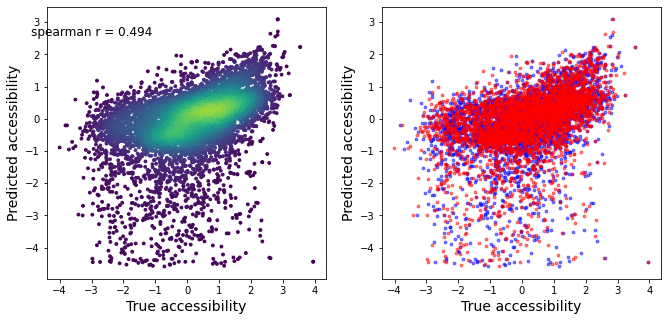

In [4]:
# Overall Spearman plot:
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde, spearmanr
plt.rcParams['figure.figsize'] = 11, 5

x, y = y_test, y_pred
cor = spearmanr(x,y).correlation

xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

fig, ax = plt.subplots(1,2)
ax[0].scatter(x, y, c=z, s=8, vmax = 0.2)
ax[1].scatter(x[:len(x)//2], y[:len(y)//2], c='b', s=8, vmax = 0.2, alpha=0.5)
ax[1].scatter(x[len(x)//2:], y[len(y)//2:], c='r', s=8, vmax = 0.2, alpha=0.5)
ax[0].set_ylabel('Predicted accessibility', fontsize = 14)
ax[0].set_xlabel('True accessibility', fontsize = 14)
ax[1].set_ylabel('Predicted accessibility', fontsize = 14)
ax[1].set_xlabel('True accessibility', fontsize = 14)
ax[0].text(-3, 2.5, 'spearman r = {:.3f}'.format(cor), 
         ha='center', va='bottom',fontsize=12)
plt.show()

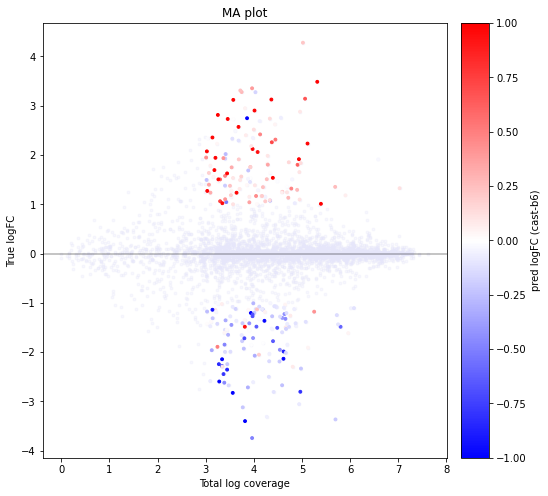

In [5]:
# MA plot
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="7%", pad=0.2,)

_,_,_,_,temp,_ = load_data(ctype,dataset,'_noGC'+ident+'')        # load no GC dataset to get total log coverage
temp = temp[:len(temp)//2]
totalcov = np.log2(2**temp[:len(y_test)//2]+2**temp[len(y_test)//2:]-1)
idx_sig = np.where(np.logical_and(totalcov>3, np.abs(true_fc)>1) )[0]

ax.axhline(0, c='k', alpha=0.3)
ax.scatter(totalcov , true_fc, c = 'lavender', cmap = 'bwr', s = 8, vmax=1, vmin=-1, alpha=0.3 )
a = ax.scatter(totalcov[idx_sig] , true_fc[idx_sig], c = pred_fc[idx_sig], cmap = 'bwr', s = 8, vmax=1, vmin=-1 )
# a = ax.scatter(totalcov , true_fc, c = pred_fc, cmap = 'bwr', s = 8, vmax=1, vmin=-1 )
cbar = plt.colorbar(a, cax=cax)
cbar.set_label('pred logFC (cast-b6)')
ax.set_xlabel('Total log coverage')
ax.set_ylabel('True logFC')
ax.set_title('MA plot')
plt.show()

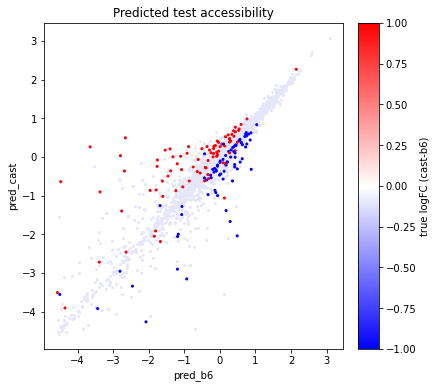

In [6]:
# Allele Specific predictions plot:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="7%", pad=0.2,)

idx = np.where(np.abs(pred_fc)>0.1)[0]
idx = list(set(idx_sig).intersection(idx))

ax.scatter(y_pred[:len(y_pred)//2], y_pred[len(y_pred)//2:],
            vmax = 1, vmin = -1, cmap = 'bwr',s = 4,
           c = 'lavender')
a = ax.scatter(y_pred[:len(y_pred)//2][idx], y_pred[len(y_pred)//2:][idx],
            vmax = 1, vmin = -1, cmap = 'bwr',s = 4,
           c = true_fc[idx])
cbar = plt.colorbar(a, cax=cax)
cbar.set_label('true logFC (cast-b6)')
ax.set_title('Predicted test accessibility')
ax.set_xlabel('pred_b6')
ax.set_ylabel('pred_cast')
plt.show()

KstestResult(statistic=0.6575342465753424, pvalue=3.1830435541803285e-15)


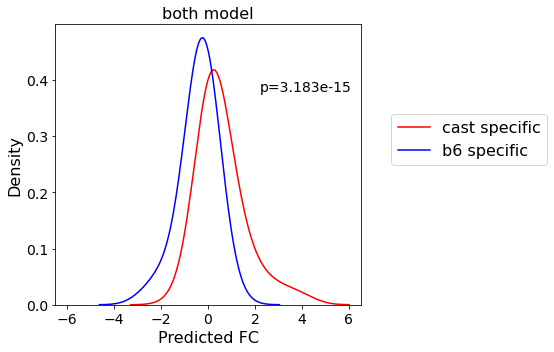

In [7]:
# KDE plot:
import seaborn as sns
from scipy.stats import ks_2samp

plt.rcParams['figure.figsize'] = 8, 5

# perform KS test on the peaks with foldchange in the top and bottom 2 percntile 
# pred_fc is the predicted foldchange and pred_fc_r is the predicted foldchange of the reverse complement
ks = ks_2samp(pred_fc[(true_fc)>np.percentile(true_fc, 98)],
              pred_fc[(true_fc)<np.percentile(true_fc, 2)])
print(ks)
sns.kdeplot(pred_fc[true_fc > np.percentile(true_fc, 98)], 
            color = 'red', bw = 0.7,legend = True,label="cast specific", linestyle="-")
sns.kdeplot(pred_fc[true_fc < np.percentile(true_fc, 2)], 
            color = 'blue', bw = 0.7,legend = True,label="b6 specific", linestyle="-")
plt.xlim(-6.5,6.5)
plt.xlabel('Predicted FC', fontsize = 16)
plt.ylabel('Density', fontsize = 16)
plt.title(dataset+' model', fontsize = 16)
plt.legend(fontsize = 16, loc = [1.1,0.5])
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.text(2.2,0.38,'p={0:.3e}'.format(ks.pvalue), fontsize = 14)
plt.tight_layout()

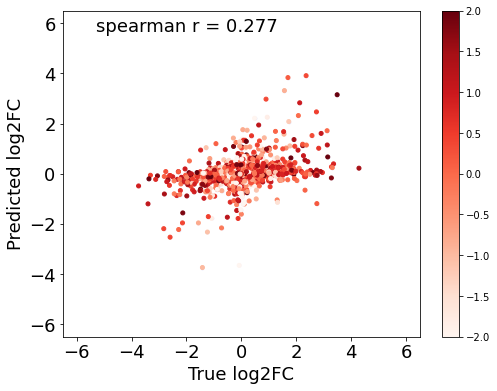

In [8]:
# Red spearman plot for fc
plt.rcParams['figure.figsize'] = 8, 6
fc_cutoff = 0. # Cutoff for peak foldchange. Points with lower absolute fold-change are greyed out

cor2 = spearmanr(true_fc[abs(true_fc)>fc_cutoff],pred_fc[abs(true_fc)>fc_cutoff]).correlation

plt.scatter(true_fc,pred_fc,vmax = 2, vmin = -2, s = 8, c = 'lavender')
plt.scatter(
           true_fc[abs(true_fc)>fc_cutoff],pred_fc[abs(true_fc)>fc_cutoff],
            vmax = 2, vmin = -2, cmap = 'Reds',s = 16, 
    c = np.max(np.array([y_test[:len(y_test)//2],
                y_test[len(y_test)//2:]]), axis = 0
      )[abs(true_fc)>fc_cutoff]
)
plt.ylabel('Predicted log2FC', fontsize = 18)
plt.xlabel('True log2FC', fontsize = 18)
plt.text(-2, 5.5, 'spearman r = {:.3f}'.format(cor2), 
         ha='center', va='bottom',fontsize=18)
plt.colorbar()
plt.xlim(-6.5,6.5)
plt.ylim(-6.5,6.5)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.title('')
plt.show()

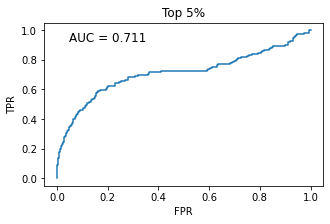

In [9]:
from sklearn.metrics import precision_recall_curve, roc_curve, roc_auc_score
def plot_auc(x,y,name):
    if name=='roc':
        prc = roc_curve(x,y)
        plt.plot(prc[0],prc[1])
        plt.ylabel('TPR')
        plt.xlabel('FPR')
    elif name=='prc':
        prc = precision_recall_curve(x,y)
        plt.plot(prc[0],prc[1])
        plt.ylabel('Precision')
        plt.xlabel('Recall')
    plt.text(0.2, 0.9, 'AUC = {:.3f}'.format(roc_auc_score(x,y)), ha='center', va='bottom',fontsize=12)
    return

plt.figure(figsize=(5,3))
thresh = np.percentile(true_fc, 95)
plot_auc(true_fc >= thresh, pred_fc, 'roc')
plt.title('Top 5%')
plt.show()

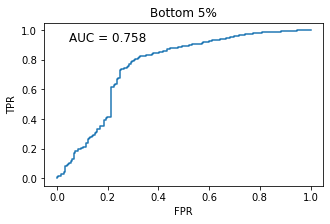

In [10]:
plt.figure(figsize=(5,3))
thresh = np.percentile(true_fc, 5)
plot_auc(true_fc >= thresh, pred_fc, 'roc')
plt.title('Bottom 5%')
plt.show()

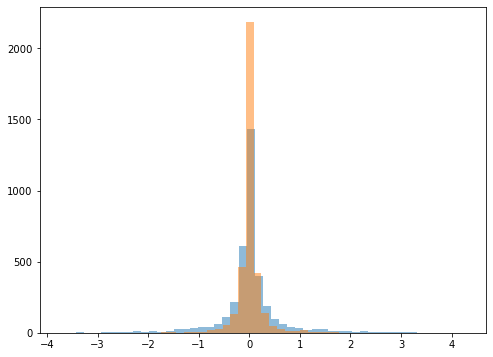

In [11]:
import matplotlib.pyplot as plt
# distribution of true and predicted log FC
plt.hist(true_fc, bins=50, alpha=0.5)
plt.hist(pred_fc, bins=50, alpha=0.5)
plt.show()

# Feature Attribution

In [12]:
def unhot(x):
    # input shape (n,len,4)
    # output shape (n,len)
    x_dna = np.full((x.shape[0],x.shape[1]), 'N')
    nucs = ['A','C','G','T']
    for i in range(len(x)):
        for j in range(len(nucs)):
            idx = np.where(x_test[i,:,j])[0]
            x_dna[i][idx] = nucs[j]
    x_dna = np.array([''.join(x_dna[i]) for i in range(len(x_dna))])
    return x_dna

In [20]:
summits = pd.read_csv(aligndir+'cd8_old/yi_cd8_peaks_34075.csv',sep=',',index_col=0)
summits['start'] += 150
temp = summits.iloc[:,0]
summits = summits.iloc[:,1:3]
summits.columns = range(2)

In [39]:
# finding a particular summit
c = 12
# temp = summits.iloc[np.where(summits[0]==c)[0],:]
temp = temp.iloc[list(set(np.where(temp[1]>4065561)[0]).intersection(set(np.where(temp[1]<4065860)[0])) )[0], 1]

In [13]:
# extract DNA sequence corresponding to the summit region
from Bio import SeqIO
gen_b6 = SeqIO.index(aligndir+'gen/b6.fa', 'fasta')
seq_b6 = ''.join(gen_b6.get_raw(str(c)).decode().split('\n')[1:])

NameError: name 'c' is not defined

In [18]:
import torch
from run import alleleScan, load_data
from captum.attr import IntegratedGradients, DeepLift
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

dataset = 'both'
model = alleleScan(2, 0.2)
model.to(DEVICE)
SAVEPATH = f'{basedir}mouseASA/ckpt_models/{ctype}/{ctype}_{modelname}_{dataset}_{use_prior}_{batchsize}{gc}{ident}.hdf5'
print(SAVEPATH)
model.load_state_dict(torch.load(SAVEPATH))
model.eval()

dl = DeepLift(model)

_, x_test, _, _, y_test, _ = load_data(ctype, dataset, gc+ident)
x_test = x_test[:len(x_test)//2]                     # remove revcomps
y_test = y_test[:len(y_test)//2]
x_test_dna = unhot(x_test)

# x_test: one-hot encoded 300bp sequence inputs with shape (n, 300, 4)
attr = dict()
for k in ['dl']:
    attr[k] = []

for i in tqdm( range(0, len(x_test), int(batchsize)) ):
    test_input_tensor = torch.from_numpy(x_test[i:i+int(batchsize)]).type(torch.FloatTensor).transpose(1,2).to(DEVICE)
    test_input_tensor.requires_grad_()
    attr['dl'].append(dl.attribute(test_input_tensor).detach().cpu().numpy())
    
for k in attr.keys():
    attr[k] = np.concatenate(attr[k])

/data/leslie/shared/ASA/mouseASA/ckpt_models/cd8/cd8_m3_both_1_32_vi_150bp.hdf5


  0%|          | 0/228 [00:00<?, ?it/s]

/home/sinhaa2/anaconda3/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:336: UserWarning: Setting forward, backward hooks and attributes on non-linear
               activations. The hooks and attributes will be removed
            after the attribution is finished
  warnings.warn(
/home/sinhaa2/anaconda3/lib/python3.8/site-packages/captum/attr/_core/deep_lift.py:467: UserWarning: An invalid module MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False) is detected. Saved gradients will
                be used as the gradients of the module's input tensor.
                See MaxPool1d as an example.
  warnings.warn(


In [18]:
if ident[:3]=='_vi':
    summits = pd.read_csv(aligndir+'cd8_old/yi_cd8_peaks_34075.csv',sep=',',index_col=0)
    summits['start'] += 150
    summits = summits.iloc[:,1:3]
    summits.columns = range(2)
else:
    summits = pd.read_csv(f'{basedir}mouseASA/data/{ctype}/summits{ident}.csv', header=None)
print(len(summits))

chromsummits = []
for i in chrom_test:
    chromsummits.append(np.array(summits.loc[np.where(summits[0]==i)[0],1]))
chromsummits = np.concatenate(chromsummits)

34075


In [21]:
import gzip

def get_loci(mods, c, summit):
    mod_c = [x for x in mods if '\t'+str(c)+'\t' in x]
    mod_c = pd.DataFrame([x.split('\t') for x in mod_c])
    mod_c[2] = mod_c[2].astype(int)
    temp = mod_c.iloc[np.where(np.logical_and(mod_c[2]>=summit-150, mod_c[2]<=summit+150))[0], :]
    # insert clever code to deal with dels
    loci = list(temp[2]-(summit-150)+1)
    return loci

# load modfile for SNP and indel locations
modfile = aligndir+'gen/cast.mod'
with gzip.open(modfile,'rt') as f:
    mods = f.read().split('\n')
    mods = [x for x in mods if not x.startswith('#')][:-1]            # filter out header lines
    mods = [x for x in mods for c in chrom_test if '\t'+str(c)+'\t' in x]   # filter to only the chromosomes of interest

In [22]:
# Get sorted fc for ranking of differentially accessible peaks
temp = np.sort( np.abs(true_fc) )[::-1]

chr15: 86195070-86195370
SNP/Indel location: [12, 29, 48, 216, 231, 269]
True Log2fc (cast/b6): 4.279732252295876
b6       DeepLIFT


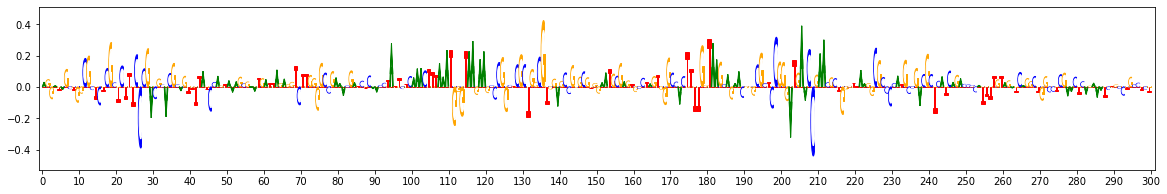

cast     DeepLIFT


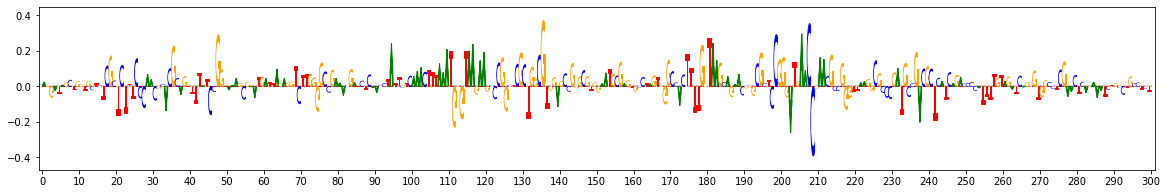

In [24]:
from Bio.Seq import Seq
from Bio import pairwise2
import deeplift
from deeplift.visualization import viz_sequence
import matplotlib.patches

rank = 1       # fold change rank of true accessibility change
i = np.where(np.abs(true_fc)==temp[rank-1])[0][0]
if i>=len( np.array(summits.loc[np.where(summits[0]==chrom_test[0])[0],1]) ):
    c = chrom_test[1]
else:
    c = chrom_test[0]

seq_b6 = x_test_dna[i]
seq_ca = x_test_dna[len(x_test_dna)//2+i]

# get locations of SNPs and indels
idx = get_loci(mods, c, chromsummits[i])

print(f'chr{c}: {chromsummits[i]-150}-{chromsummits[i]+150}')
print('SNP/Indel location:', idx)
print('True Log2fc (cast/b6):', true_fc[i])

for k in attr.keys():
    if k=='ig':
        method_name = 'Integrated Gradient'
    elif k=='dl':
        method_name = 'DeepLIFT'
    
    scores_b6 = x_test[i]*attr[k][i].T
    scores_ca = x_test[i+len(x_test)//2]*attr[k][i+len(x_test)//2].T
    print('Both model      ', method_name)
    viz_sequence.plot_weights(scores_b6, subticks_frequency=10, figsize = (20,3))
    print('cast    ', method_name)
    viz_sequence.plot_weights(scores_ca, subticks_frequency=10, figsize = (20,3))

In [ ]:
print('True fc: {:.3f}'.format(true_fc[i]) )
print('Pred fc: {:.3f}'.format(pred_fc[i]) )
print('b6 true acc: {:.3f}'.format(y_test[i]) )
print('b6 pred acc: {:.3f}'.format(y_pred[i]) )
print('cast true acc: {:.3f}'.format(y_test[i+len(y_test)//2]) )
print('cast pred acc: {:.3f}'.format(y_pred[i+len(y_pred)//2]) )